In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import tensorflow as tf
from sentence_transformers import SentenceTransformer, util
from InstructorEmbedding import INSTRUCTOR
from transformers import AutoModel
import torch

In [4]:
""" module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url) """

roberta_model = SentenceTransformer('stsb-roberta-large')
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
distilbert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')
instructor_model = INSTRUCTOR('hkunlp/instructor-large') #instructor-large
""" anita_model = "DeepMount00/Anita"
labse_model = "LaBSE" """
""" e5_model = SentenceTransformer('intfloat/e5-large-v2') """
t5_model = SentenceTransformer('sentence-transformers/sentence-t5-xl')
distilbert_modelv2 = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')

load INSTRUCTOR_Transformer
max_seq_length  512


In [5]:
# Process for Question 1
df_q1 = pd.read_excel('new_processed-answers.xlsx', sheet_name='Q-1')

# Assuming answers are in the third column
answers_q1 = df_q1.iloc[:, 1].fillna('').tolist()
scores_q1 = df_q1.iloc[:, 2].fillna(0).tolist()

print(answers_q1)

#query_q1 = 'The Arabs made significant contributions to mathematics, astronomy, medicine, chemistry, and engineering. Notably, the development of algebra and algorithms, the optical works of Ibn al-Haytham, the medical encyclopedia "The Canon of Medicine" by Avicenna, and the contributions to trigonometry by Abū al-Wafā\' are foundational. Additionally, the mathematical and astronomical works of Al-Khwarizmi are cornerstone contributions, highlighting the Arabs\' role in shaping modern science.'

query_q1 = "Arab contributions to science include groundbreaking work in optics, the development of algebra and algorithms, advancements in cartography and navigation, the translation and preservation of ancient knowledge, and significant discoveries in medicine and surgery."

# ST modeli ile vektörleri hesapla
roberta_vectors = roberta_model.encode(answers_q1 + [query_q1], convert_to_tensor=True)
roberta_query_vector = roberta_vectors[-1]
roberta_cosine_similarities = util.pytorch_cos_sim(roberta_vectors[:-1], roberta_query_vector)

# ST modeli 2 ile vektörleri hesapla ama orijinal score değeri 0 olanların içinde cevap boş ise skor 0 olacak
bert_vectors = bert_model.encode(answers_q1 + [query_q1], convert_to_tensor=True)
bert_query_vector = bert_vectors[-1]
bert_cosine_similarities = util.pytorch_cos_sim(bert_vectors[:-1], bert_query_vector)

""" # Anita modeli ile vektörleri hesapla
anita_vectors = roberta_model.encode(answers_q1 + [query_q1], convert_to_tensor=True)
anita_query_vector = anita_vectors[-1]
anita_cosine_similarities = util.pytorch_cos_sim(anita_vectors[:-1], anita_query_vector)

# LaBSE modeli ile vektörleri hesapla
labse_vectors = roberta_model.encode(answers_q1 + [query_q1], convert_to_tensor=True)
labse_query_vector = labse_vectors[-1]
labse_cosine_similarities = util.pytorch_cos_sim(labse_vectors[:-1], labse_query_vector) """

""" # E5 modeli ile vektörleri hesapla
e5_vectors = e5_model.encode(answers_q1 + [query_q1], convert_to_tensor=True)
e5_query_vector= e5_vectors[-1]
e5_cosine_similarities = util.pytorch_cos_sim(e5_vectors[:-1], e5_query_vector) """


# DistilBERT modeli ile vektörleri hesapla
distilbert_vectors = distilbert_model.encode(answers_q1 + [query_q1], convert_to_tensor=True)
distilbert_query_vector = distilbert_vectors[-1]
distilbert_cosine_similarities = util.pytorch_cos_sim(distilbert_vectors[:-1], distilbert_query_vector)

# DistilBERT modeli v2 ile vektörleri hesapla
distilbert_vectorsv2 = distilbert_modelv2.encode(answers_q1 + [query_q1], convert_to_tensor=True)
distilbert_query_vectorv2 = distilbert_vectorsv2[-1]
distilbert_cosine_similaritiesv2 = util.pytorch_cos_sim(distilbert_vectorsv2[:-1], distilbert_query_vectorv2)

# Instructor modeli ile vektörleri hesapla
instructor_vectors = instructor_model.encode(answers_q1 + [query_q1], convert_to_tensor=True)
instructor_query_vector = instructor_vectors[-1]
instructor_cosine_similarities = util.pytorch_cos_sim(instructor_vectors[:-1], instructor_query_vector)
# T5 modeli ile vektörleri hesapla
t5_vectors = t5_model.encode(answers_q1 + [query_q1], convert_to_tensor=True)
t5_query_vector = t5_vectors[-1]
t5_cosine_similarities = util.pytorch_cos_sim(t5_vectors[:-1], t5_query_vector)

# Öğrenci cevaplarının boş olup olmadığını kontrol etmek için bir fonksiyon
def check_if_answer_is_empty(answer):
    # Cevap eğer boş bir string veya sadece boşluklardan oluşuyorsa True döner
    return answer.strip() == ""


# Cevapların boş olup olmadığını kontrol et ve bir mask oluştur
empty_answer_mask = [check_if_answer_is_empty(answer) for answer in answers_q1]
# Score değeri 0 olan cevapların indekslerini bir PyTorch maskesi olarak oluştur
#zero_score_mask = torch.tensor(scores_q1) == 0

# Bu maski kullanarak, ilgili skorlar cevapları da boş ise sıfıra ayarla
""" def adjust_scores_for_zero(cosine_similarities, mask):
    adjusted_scores = cosine_similarities.clone()  # Orjinal tensörü değiştirmemek için klonla
    adjusted_scores[mask] = 0  # Mask ile belirtilen indekslerdeki değerleri sıfırla
    return adjusted_scores """

# Cosine benzerlik skorlarını hesapla ve boş cevaplar için skorları ayarla
def adjust_scores(cosine_similarities, empty_mask):
    adjusted_scores = cosine_similarities.clone().detach()  # Tensörü klonla ve detach yap
    for i, is_empty in enumerate(empty_mask):
        if is_empty:  # Eğer cevap boşsa
            adjusted_scores[i] = 0  # İlgili skoru sıfıra ayarla
    return adjusted_scores
# Şimdi, her bir model için bu fonksiyonu kullanarak skorları ayarlayın
roberta_cosine_similarities = adjust_scores(roberta_cosine_similarities, empty_answer_mask)
bert_cosine_similarities = adjust_scores(bert_cosine_similarities, empty_answer_mask)
distilbert_cosine_similarities = adjust_scores(distilbert_cosine_similarities, empty_answer_mask)
distilbert_cosine_similaritiesv2 = adjust_scores(distilbert_cosine_similaritiesv2, empty_answer_mask)
instructor_cosine_similarities = adjust_scores(instructor_cosine_similarities, empty_answer_mask)
t5_cosine_similarities = adjust_scores(t5_cosine_similarities, empty_answer_mask)
df_q1['Roberta Score'] = np.round(roberta_cosine_similarities.numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak
df_q1['Bert Score'] = np.round(bert_cosine_similarities.numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak
df_q1['DistilBert Score'] = np.round(distilbert_cosine_similarities.numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak
""" df_q1['Anita Score'] = np.round(anita_cosine_similarities.numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak
df_q1['LaBSE Score'] = np.round(labse_cosine_similarities.numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak """
#df_q1['E5 Score'] = np.round(e5_cosine_similarities.numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak
df_q1['DistilBert Score v2'] = np.round(distilbert_cosine_similaritiesv2.numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak
df_q1['Instructor Score'] = np.round(instructor_cosine_similarities.numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak
df_q1['T5 Score'] = np.round(t5_cosine_similarities.numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak

# İlk birkaç satırı göster
df_q1.head()

['arabs contributed important concepts like optics surgery quarantine prevent spread diseases algebra algorithm invented paper enabled punishments house wisdom baghdad speak algorithm al - khwarizmi easily accepted father algorithm word derived word quit algebra quit latin term', 'ali ku credit u proved astronomical facts evidence allowing astronomy separated religion books medicine improved eye ear throat surgeries ibn sina wrote book medicine piri reis drew world map combination maps creating world map', 'estimate number days year geography need know makea time', 'samarkand school geography astronomy provided primary sources ottoman s knowledge geography map - making related fields p d ispasted emp brief liquor learn knowledge china basis promoted science invested progress arabs arabs developed algebra alchemy algorithm average almanac aorta alcohol arabic origin words finding direction mecca pray time required accurate measurement time location sphere shape earth dash establishment 

,StudentID,Answer,Score,Roberta Score,Bert Score,DistilBert Score,DistilBert Score v2,Instructor Score,T5 Score
0,20190808014,arabs contributed important concepts like opti...,20,12,12,13,9,18,18
1,20190808021,ali ku credit u proved astronomical facts evid...,8,10,13,13,6,18,16
2,20190808035,estimate number days year geography need know ...,4,3,6,4,3,16,12
3,20200808003,samarkand school geography astronomy provided ...,14,11,13,14,9,18,17
4,20200808008,glass optics omar khayyam described laws refle...,18,9,9,10,7,18,16


In [6]:
# Process for Question 1
df_q2 = pd.read_excel('new_processed-answers.xlsx', sheet_name='Q-2')

# Assuming answers are in the third column
answers_q2 = df_q2.iloc[:, 1].fillna('').tolist()
scores_q2 = df_q2.iloc[:, 2].fillna(0).tolist()

print(answers_q2)


query_q2 = "The Roman Empire's contributions to the legal system include the development of the Twelve Tables, which laid the foundation for Roman law, influencing modern legal systems with concepts of democracy, division of power, legal rights in trade and conflict, and the basis for evidence and proof in judicial proceedings."

# ST modeli ile vektörleri hesapla
roberta_vectors2 = roberta_model.encode(answers_q2 + [query_q2], convert_to_tensor=True)
roberta_query_vector2 = roberta_vectors2[-1]
roberta_cosine_similarities2 = util.pytorch_cos_sim(roberta_vectors2[:-1], roberta_query_vector2)

# ST modeli 2 ile vektörleri hesapla
bert_vectors2 = bert_model.encode(answers_q2 + [query_q2], convert_to_tensor=True)
bert_query_vector2 = bert_vectors2[-1]
bert_cosine_similarities2 = util.pytorch_cos_sim(bert_vectors2[:-1], bert_query_vector2)

# DistilBERT modeli ile vektörleri hesapla
distilbert_vectors2 = distilbert_model.encode(answers_q2 + [query_q2], convert_to_tensor=True)
distilbert_query_vector2 = distilbert_vectors2[-1]
distilbert_cosine_similarities2 = util.pytorch_cos_sim(distilbert_vectors2[:-1], distilbert_query_vector2)

# DistilBERT modeli v2 ile vektörleri hesapla
distilbert_vectorsv2 = distilbert_modelv2.encode(answers_q2 + [query_q2], convert_to_tensor=True)
distilbert_query_vectorv22 = distilbert_vectorsv2[-1]
distilbert_cosine_similaritiesv22 = util.pytorch_cos_sim(distilbert_vectorsv2[:-1], distilbert_query_vectorv2)

# Instructor modeli ile vektörleri hesapla
instructor_vectors2 = instructor_model.encode(answers_q2 + [query_q2], convert_to_tensor=True)
instructor_query_vector2 = instructor_vectors2[-1]
instructor_cosine_similarities2 = util.pytorch_cos_sim(instructor_vectors2[:-1], instructor_query_vector2)

""" # Anita modeli ile vektörleri hesapla
anita_vectors2 = roberta_model.encode(answers_q2 + [query_q2], convert_to_tensor=True)
anita_query_vector2 = anita_vectors2[-1]
anita_cosine_similarities2 = util.pytorch_cos_sim(anita_vectors2[:-1], anita_query_vector2)

# LaBSE modeli ile vektörleri hesapla
labse_vectors2 = roberta_model.encode(answers_q2 + [query_q2], convert_to_tensor=True)
labse_query_vector2 = labse_vectors2[-1]
labse_cosine_similarities2 = util.pytorch_cos_sim(labse_vectors2[:-1], labse_query_vector2) """

""" # E5 modeli ile vektörleri hesapla
e5_vectors2 = e5_model.encode(answers_q2 + [query_q2], convert_to_tensor=True)
e5_query_vector2 = e5_vectors2[-1]
e5_cosine_similarities2 = util.pytorch_cos_sim(e5_vectors2[:-1], e5_query_vector2) """

# T5 modeli ile vektörleri hesapla
t5_vectors2 = t5_model.encode(answers_q2 + [query_q2], convert_to_tensor=True)
t5_query_vector2 = t5_vectors2[-1]
t5_cosine_similarities2 = util.pytorch_cos_sim(t5_vectors2[:-1], t5_query_vector2)

# Cevapların boş olup olmadığını kontrol et ve bir mask oluştur
empty_answer_mask = [check_if_answer_is_empty(answer) for answer in answers_q1]
# Score değeri 0 olan cevapların indekslerini bir PyTorch maskesi olarak oluştur
#zero_score_mask = torch.tensor(scores_q1) == 0

# Bu maski kullanarak, ilgili skorlar cevapları da boş ise sıfıra ayarla
""" def adjust_scores_for_zero(cosine_similarities, mask):
    adjusted_scores = cosine_similarities.clone()  # Orjinal tensörü değiştirmemek için klonla
    adjusted_scores[mask] = 0  # Mask ile belirtilen indekslerdeki değerleri sıfırla
    return adjusted_scores """

# Cosine benzerlik skorlarını hesapla ve boş cevaplar için skorları ayarla
def adjust_scores(cosine_similarities, empty_mask):
    adjusted_scores = cosine_similarities.clone().detach()  # Tensörü klonla ve detach yap
    for i, is_empty in enumerate(empty_mask):
        if is_empty:  # Eğer cevap boşsa
            adjusted_scores[i] = 0  # İlgili skoru sıfıra ayarla
    return adjusted_scores
# Şimdi, her bir model için bu fonksiyonu kullanarak skorları ayarlayın
roberta_cosine_similarities2 = adjust_scores(roberta_cosine_similarities2, empty_answer_mask)
bert_cosine_similarities2 = adjust_scores(bert_cosine_similarities2, empty_answer_mask)
distilbert_cosine_similarities2 = adjust_scores(distilbert_cosine_similarities2, empty_answer_mask)
distilbert_cosine_similaritiesv22 = adjust_scores(distilbert_cosine_similaritiesv22, empty_answer_mask)
instructor_cosine_similarities2 = adjust_scores(instructor_cosine_similarities2, empty_answer_mask)
""" anita_cosine_similarities = adjust_scores(anita_cosine_similarities, empty_answer_mask)
labse_cosine_similarities = adjust_scores(labse_cosine_similarities, empty_answer_mask) """
#e5_cosine_similarities = adjust_scores(e5_cosine_similarities, empty_answer_mask)
t5_cosine_similarities = adjust_scores(t5_cosine_similarities, empty_answer_mask)

# Notları hesapla ve DataFrame'e ekle
#df_q1['USE Score'] = np.round(use_cosine_similarities * 20).astype(int)  # USE skoru, tamsayı olarak
df_q2['Roberta Score'] = np.round(roberta_cosine_similarities2.numpy().flatten() * 20).astype(int)  # ST skoru, tamsayı olarak
df_q2['Bert Score'] = np.round(bert_cosine_similarities2.numpy().flatten() * 20).astype(int)  # ST2 skoru, tamsayı olarak
df_q2['DistilBert Score'] = np.round(distilbert_cosine_similarities2.numpy().flatten() * 20).astype(int)  # DistilBERT skoru, tamsayı olarak
df_q2['DistilBert Score v2'] = np.round(distilbert_cosine_similaritiesv2.numpy().flatten() * 20).astype(int)  # DistilBERT V2 skoru, tamsayı olarak
df_q2['Instructor Score'] = np.round(instructor_cosine_similarities2.numpy().flatten() * 20).astype(int)  # Instructor skoru, tamsayı olarak
""" df_q2['Anita Score'] = np.round(anita_cosine_similarities2.numpy().flatten() * 20).astype(int)  # Anita skoru, tamsayı olarak
df_q2['LaBSE Score'] = np.round(labse_cosine_similarities2.numpy().flatten() * 20).astype(int)  # LaBSE skoru, tamsayı olarak """
#df_q2['E5 Score'] = np.round(e5_cosine_similarities2.numpy().flatten() * 20).astype(int)  # E5 skoru, tamsayı olarak
df_q2['T5 Score'] = np.round(t5_cosine_similarities2.numpy().flatten() * 20).astype(int)  # T5 skoru, tamsayı olarak


# İlk birkaç satırı göster
df_q2.head()

['advanced modern legal system civil engineering military engineering like gregorian calendar divided powers known division powers 3 parties consuls senate assemblies mention conflict interests example senators forbidden trade influences gains trading terms theaters having great open - air settings tales gods love etc romanian theater stories closed realistic shows acted makes theater influence democracy', 'main battlefield surgeries bound books 12 tables julian calendar aqueducts roman bridges roads highways newspapers welfare concrete working mathematical philosophical astronomical improvements worked military building law improvements thinker builder', 'roads highways geometry military engineering science changes life', '', 'achieved civil army engineering republic government system fundamentals modern legal systems road trade web europe rule medittarenean hundreds years seeking answers questions nature developing theories philosophies developed science philosophy improved tools arm

,StudentID,Answer,Score,Roberta Score,Bert Score,DistilBert Score,DistilBert Score v2,Instructor Score,T5 Score
0,20190808014,advanced modern legal system civil engineering...,17,7,11,10,9,18,16
1,20190808021,main battlefield surgeries bound books 12 tabl...,18,10,14,13,6,17,17
2,20190808035,roads highways geometry military engineering s...,11,5,10,10,3,16,13
3,20200808003,NaN,0,1,0,1,9,16,12
4,20200808008,achieved civil army engineering republic gover...,17,9,13,12,7,17,16


In [7]:
# Process for Question 3
df_q3 = pd.read_excel('new_processed-answers.xlsx', sheet_name='Q-3')

# Assuming answers are in the third column
answers_q3 = df_q3.iloc[:, 1].fillna('').tolist()
scores_q3 = df_q3.iloc[:, 2].fillna(0).tolist()

print(answers_q3)

query_q3 = 'In Medieval Europe, education played a crucial role in developing the legal system, particularly in establishing the principles of proving innocence or guilt, the use of juries and trials for judicial processes, and the reliance on precedents and legal expertise, drawing from earlier foundations like the Twelve Tables.'
# ST modeli ile vektörleri hesapla
roberta_vectors3 = roberta_model.encode(answers_q3 + [query_q3], convert_to_tensor=True)
roberta_query_vector3 = roberta_vectors3[-1]
roberta_cosine_similarities3 = util.pytorch_cos_sim(roberta_vectors3[:-1], roberta_query_vector3)

# ST modeli 2 ile vektörleri hesapla
bert_vectors3 = bert_model.encode(answers_q3 + [query_q3], convert_to_tensor=True)
bert_query_vector3 = bert_vectors3[-1]
bert_cosine_similarities3 = util.pytorch_cos_sim(bert_vectors3[:-1], bert_query_vector3)

# DistilBERT modeli ile vektörleri hesapla
distilbert_vectors3 = distilbert_model.encode(answers_q3 + [query_q3], convert_to_tensor=True)
distilbert_query_vector3 = distilbert_vectors3[-1]
distilbert_cosine_similarities3 = util.pytorch_cos_sim(distilbert_vectors3[:-1], distilbert_query_vector3)

# DistilBERT modeli v2 ile vektörleri hesapla
distilbert_vectorsv3 = distilbert_modelv2.encode(answers_q3 + [query_q3], convert_to_tensor=True)
distilbert_query_vectorv23 = distilbert_vectorsv3[-1]
distilbert_cosine_similaritiesv3 = util.pytorch_cos_sim(distilbert_vectorsv3[:-1], distilbert_query_vectorv23)

# Instructor modeli ile vektörleri hesapla
instructor_vectors3 = instructor_model.encode(answers_q3 + [query_q3], convert_to_tensor=True)
instructor_query_vector3 = instructor_vectors3[-1]
instructor_cosine_similarities3 = util.pytorch_cos_sim(instructor_vectors3[:-1], instructor_query_vector3)

""" # Anita modeli ile vektörleri hesapla
anita_vectors3 = roberta_model.encode(answers_q3 + [query_q3], convert_to_tensor=True)
anita_query_vector3 = anita_vectors3[-1]
anita_cosine_similarities3 = util.pytorch_cos_sim(anita_vectors3[:-1], anita_query_vector3)

# LaBSE modeli ile vektörleri hesapla
labse_vectors3 = roberta_model.encode(answers_q3 + [query_q3], convert_to_tensor=True)
labse_query_vector3 = labse_vectors3[-1]
labse_cosine_similarities3 = util.pytorch_cos_sim(labse_vectors3[:-1], labse_query_vector3) """

""" # E5 modeli ile vektörleri hesapla
e5_vectors3 = e5_model.encode(answers_q3 + [query_q3], convert_to_tensor=True)
e5_query_vector3 = e5_vectors3[-1]
e5_cosine_similarities3 = util.pytorch_cos_sim(e5_vectors3[:-1], e5_query_vector3) """

# T5 modeli ile vektörleri hesapla
t5_vectors3 = t5_model.encode(answers_q3 + [query_q3], convert_to_tensor=True)
t5_query_vector3 = t5_vectors3[-1]
t5_cosine_similarities3 = util.pytorch_cos_sim(t5_vectors3[:-1], t5_query_vector3)

# Score değeri 0 olan cevapların indekslerini bir PyTorch maskesi olarak oluştur
zero_score_mask3 = torch.tensor(scores_q3) == 0

# Bu maski kullanarak, ilgili skorları sıfıra ayarla
def adjust_scores_for_zero(cosine_similarities3, mask):
    adjusted_scores3 = cosine_similarities3.clone()  # Orjinal tensörü değiştirmemek için klonla
    adjusted_scores3[mask] = 0  # Mask ile belirtilen indekslerdeki değerleri sıfırla
    return adjusted_scores3

# Şimdi, her bir model için bu fonksiyonu kullanarak skorları ayarlayın
roberta_cosine_similarities3 = adjust_scores_for_zero(roberta_cosine_similarities3, zero_score_mask3)
bert_cosine_similarities3 = adjust_scores_for_zero(bert_cosine_similarities3, zero_score_mask3)
distilbert_cosine_similarities3 = adjust_scores_for_zero(distilbert_cosine_similarities3, zero_score_mask3)
distilbert_cosine_similaritiesv3 = adjust_scores_for_zero(distilbert_cosine_similaritiesv3, zero_score_mask3)
instructor_cosine_similarities3 = adjust_scores_for_zero(instructor_cosine_similarities3, zero_score_mask3)
""" anita_cosine_similarities3 = adjust_scores_for_zero(anita_cosine_similarities3, zero_score_mask3)
labse_cosine_similarities3 = adjust_scores_for_zero(labse_cosine_similarities3, zero_score_mask3) """
#e5_cosine_similarities3 = adjust_scores_for_zero(e5_cosine_similarities3, zero_score_mask3)
t5_cosine_similarities3 = adjust_scores_for_zero(t5_cosine_similarities3, zero_score_mask3)

# Notları hesapla ve DataFrame'e ekle
#df_q1['USE Score'] = np.round(use_cosine_similarities * 20).astype(int)  # USE skoru, tamsayı olarak
df_q3['Roberta Score'] = np.round(roberta_cosine_similarities3.numpy().flatten() * 20).astype(int)  # ST skoru, tamsayı olarak
df_q3['Bert Score'] = np.round(bert_cosine_similarities3.numpy().flatten() * 20).astype(int)  # ST2 skoru, tamsayı olarak
df_q3['DistilBert Score'] = np.round(distilbert_cosine_similarities3.numpy().flatten() * 20).astype(int)  # DistilBERT skoru, tamsayı olarak
df_q3['DistilBert Score v2'] = np.round(distilbert_cosine_similaritiesv3.numpy().flatten() * 20).astype(int)  # DistilBERT V2 skoru, tamsayı olarak
df_q3['Instructor Score'] = np.round(instructor_cosine_similarities3.numpy().flatten() * 20).astype(int)  # Instructor skoru, tamsayı olarak
""" df_q3['Anita Score'] = np.round(anita_cosine_similarities3.numpy().flatten() * 20).astype(int)  # Anita skoru, tamsayı olarak
df_q3['LaBSE Score'] = np.round(labse_cosine_similarities3.numpy().flatten() * 20).astype(int)  # LaBSE skoru, tamsayı olarak """
#df_q3['E5 Score'] = np.round(e5_cosine_similarities3.numpy().flatten() * 20).astype(int)  # E5 skoru, tamsayı olarak
df_q3['T5 Score'] = np.round(t5_cosine_similarities3.numpy().flatten() * 20).astype(int)  # T5 skoru, tamsayı olarak


# İlk birkaç satırı göster
df_q3.head()

['introduce calendars calculate days 1 year 12 tables rule empire', 'introduce laws apply laws units like consuls assemblies senate law s 12 tables', 'checks balances vetoes separation powers term limits', 'introduced twelve tables guilty proven guilty prisons firstly equal ruler', '', 'lawyer jury juries prison', 'twelve tables rome', 'government closed consulates senate assemblies', 'lawyer improved laws way works society introduced lawyer jury system', 'revolt plebs modern judgment system like today 12 tables system 2 consuls 1 assembly 1 senate 2 consuls makes wrong decision reject decision', 'introduced modern legal concepts assemblies sent conceals distribution power important arrested innocent proofing guilty', 'introduce 12 table law introduce council prison introduce compass roads highways', 'early civilizations ruled kings priests laws punishments following laws corpus juries included modern legal concepts liquor accused innocent proven guilty duo judgment punishments based p

,StudentID,Answer,Score,Roberta Score,Bert Score,DistilBert Score,DistilBert Score v2,Instructor Score,T5 Score
0,20210808035,introduce calendars calculate days 1 year 12 t...,8,7,7,9,3,16,14
1,20220808013,introduce laws apply laws units like consuls a...,8,8,10,10,4,17,15
2,20220808706,checks balances vetoes separation powers term ...,0,0,0,0,0,0,0
3,20220808063,introduced twelve tables guilty proven guilty ...,14,10,9,8,6,17,15
4,20220808019,NaN,0,0,0,0,0,0,0


In [8]:
# Process for Question 2
df_q4 = pd.read_excel('new_processed-answers.xlsx', sheet_name='Q-4')

# Assuming answers are in the third column
answers_q4 = df_q4.iloc[:, 1].fillna('').tolist()
scores_q4 = df_q4.iloc[:, 2].fillna(0).tolist()

print(answers_q4)

query_q4 = 'The impacts of the Industrial Revolution on society were profound and multifaceted, including significant advancements in engineering and technology, akin to the discoveries in geometry by Euclid, Thales, and Pythagoras, which transformed understanding through the study of shadows, angles, and perimeters, and innovations in scientific thought and projects that paralleled the astronomical observations and mathematical deductions of ancient scholars.'
# ST modeli ile vektörleri hesapla
roberta_vectors4 = roberta_model.encode(answers_q4 + [query_q4], convert_to_tensor=True)
roberta_query_vector4 = roberta_vectors4[-1]
roberta_cosine_similarities4 = util.pytorch_cos_sim(roberta_vectors4[:-1], roberta_query_vector4)

# ST modeli 2 ile vektörleri hesapla
bert_vectors4 = bert_model.encode(answers_q4 + [query_q4], convert_to_tensor=True)
bert_query_vector4 = bert_vectors4[-1]
bert_cosine_similarities4 = util.pytorch_cos_sim(bert_vectors4[:-1], bert_query_vector4)

# DistilBERT modeli ile vektörleri hesapla
distilbert_vectors4 = distilbert_model.encode(answers_q4 + [query_q4], convert_to_tensor=True)
distilbert_query_vector4 = distilbert_vectors4[-1]
distilbert_cosine_similarities4 = util.pytorch_cos_sim(distilbert_vectors4[:-1], distilbert_query_vector4)

# DistilBERT modeli v2 ile vektörleri hesapla
distilbert_vectorsv4 = distilbert_modelv2.encode(answers_q4 + [query_q4], convert_to_tensor=True)
distilbert_query_vectorv24 = distilbert_vectorsv4[-1]
distilbert_cosine_similaritiesv4 = util.pytorch_cos_sim(distilbert_vectorsv4[:-1], distilbert_query_vectorv24)

# Instructor modeli ile vektörleri hesapla
instructor_vectors4 = instructor_model.encode(answers_q4 + [query_q4], convert_to_tensor=True)
instructor_query_vector4 = instructor_vectors4[-1]
instructor_cosine_similarities4 = util.pytorch_cos_sim(instructor_vectors4[:-1], instructor_query_vector4)

""" # Anita modeli ile vektörleri hesapla
anita_vectors4 = roberta_model.encode(answers_q4 + [query_q4], convert_to_tensor=True)
anita_query_vector4 = anita_vectors4[-1]
anita_cosine_similarities4 = util.pytorch_cos_sim(anita_vectors4[:-1], anita_query_vector4)

# LaBSE modeli ile vektörleri hesapla
labse_vectors4 = roberta_model.encode(answers_q4 + [query_q4], convert_to_tensor=True)
labse_query_vector4 = labse_vectors4[-1]
labse_cosine_similarities4 = util.pytorch_cos_sim(labse_vectors4[:-1], labse_query_vector4) """

""" # E5 modeli ile vektörleri hesapla
e5_vectors4 = e5_model.encode(answers_q4 + [query_q4], convert_to_tensor=True)
e5_query_vector4 = e5_vectors4[-1]
e5_cosine_similarities4 = util.pytorch_cos_sim(e5_vectors4[:-1], e5_query_vector4) """

# T5 modeli ile vektörleri hesapla
t5_vectors4 = t5_model.encode(answers_q4 + [query_q4], convert_to_tensor=True)
t5_query_vector4 = t5_vectors4[-1]
t5_cosine_similarities4 = util.pytorch_cos_sim(t5_vectors4[:-1], t5_query_vector4)


# Score değeri 0 olan cevapların indekslerini bir PyTorch maskesi olarak oluştur
zero_score_mask4 = torch.tensor(scores_q4) == 0

# Bu maski kullanarak, ilgili skorları sıfıra ayarla
def adjust_scores_for_zero(cosine_similarities4, mask):
    adjusted_scores4 = cosine_similarities4.clone()  # Orjinal tensörü değiştirmemek için klonla
    adjusted_scores4[mask] = 0  # Mask ile belirtilen indekslerdeki değerleri sıfırla
    return adjusted_scores4

# Şimdi, her bir model için bu fonksiyonu kullanarak skorları ayarlayın
roberta_cosine_similarities4 = adjust_scores_for_zero(roberta_cosine_similarities4, zero_score_mask4)
bert_cosine_similarities4 = adjust_scores_for_zero(bert_cosine_similarities4, zero_score_mask4)
distilbert_cosine_similarities4 = adjust_scores_for_zero(distilbert_cosine_similarities4, zero_score_mask4)
distilbert_cosine_similaritiesv4 = adjust_scores_for_zero(distilbert_cosine_similaritiesv4, zero_score_mask4)
instructor_cosine_similarities4 = adjust_scores_for_zero(instructor_cosine_similarities4, zero_score_mask4)
""" anita_cosine_similarities4 = adjust_scores_for_zero(anita_cosine_similarities4, zero_score_mask4)
labse_cosine_similarities4 = adjust_scores_for_zero(labse_cosine_similarities4, zero_score_mask4)
e5_cosine_similarities4 = adjust_scores_for_zero(e5_cosine_similarities4, zero_score_mask4) """
t5_cosine_similarities4 = adjust_scores_for_zero(t5_cosine_similarities4, zero_score_mask4)

# Notları hesapla ve DataFrame'e ekle
#df_q1['USE Score'] = np.round(use_cosine_similarities * 20).astype(int)  # USE skoru, tamsayı olarak
df_q4['Roberta Score'] = np.round(roberta_cosine_similarities4.numpy().flatten() * 20).astype(int)  # ST skoru, tamsayı olarak
df_q4['Bert Score'] = np.round(bert_cosine_similarities4.numpy().flatten() * 20).astype(int)  # ST2 skoru, tamsayı olarak
df_q4['DistilBert Score'] = np.round(distilbert_cosine_similarities4.numpy().flatten() * 20).astype(int)  # DistilBERT skoru, tamsayı olarak
df_q4['DistilBert Score v2'] = np.round(distilbert_cosine_similaritiesv4.numpy().flatten() * 20).astype(int)  # DistilBERT V2 skoru, tamsayı olarak
df_q4['Instructor Score'] = np.round(instructor_cosine_similarities4.numpy().flatten() * 20).astype(int)  # Instructor skoru, tamsayı olarak
""" df_q4['Anita Score'] = np.round(anita_cosine_similarities4.numpy().flatten() * 20).astype(int)  # Anita skoru, tamsayı olarak
df_q4['LaBSE Score'] = np.round(labse_cosine_similarities4.numpy().flatten() * 20).astype(int)  # LaBSE skoru, tamsayı olarak
df_q4['E5 Score'] = np.round(e5_cosine_similarities4.numpy().flatten() * 20).astype(int)  # E5 skoru, tamsayı olarak """
df_q4['T5 Score'] = np.round(t5_cosine_similarities4.numpy().flatten() * 20).astype(int)  # T5 skoru, tamsayı olarak



# İlk birkaç satırı göster
df_q4.head()

['aristarchus knew earths size clever application geometry deduced size earths shadow distance moon cumulativeness science', 'diameter earth known diameter moon calculated circles angles shadows moon falling earth solar eclipses diameter earth diameter moon distance earth moon calculated lunar eclipse moon stayed lunar eclipse created shadow worth 2 5 moons diameter earth calculations distance calculated', 'find height moon lunar solar eclipse calculate height thing calculate distance thing center earth', '', 'aristarchus knows size earth calculate size earths shadow moon thales intercept theorem calculate distance earth moon', '', 'observe earth moons motions earths shadow predict calculate geometry aristarchus predict moons earths weight', 'thales theorems know coin perimeter perimeter earth calculating distance earth moon ratio coin perimeter shadow earth moon point ratio coin earth perimeter equals dot earth moon mean distance', '- finding moon diameter earth diameter hypothesis ar

,StudentID,Answer,Score,Roberta Score,Bert Score,DistilBert Score,DistilBert Score v2,Instructor Score,T5 Score
0,20190808014,aristarchus knew earths size clever applicatio...,8,12,12,12,8,17,13
1,20190808021,diameter earth known diameter moon calculated ...,16,9,7,9,6,16,13
2,20190808035,find height moon lunar solar eclipse calculate...,8,10,8,9,4,16,13
3,20200808003,NaN,0,0,0,0,0,0,0
4,20200808008,aristarchus knows size earth calculate size ea...,16,11,9,9,6,16,13


In [9]:
# Process for Question 2
df_q5 = pd.read_excel('new_processed-answers.xlsx', sheet_name='Q-5')

# Assuming answers are in the third column
answers_q5 = df_q5.iloc[:, 1].fillna('').tolist()
scores_q5 = df_q5.iloc[:, 2].fillna(0).tolist()

print(answers_q5)

query_q5 = 'The effects of the Cold War on global politics included the constant reevaluation and analysis of strategies, leading to the withdrawal or modification of policies, the introduction of new hypotheses for diplomatic and military engagements, and the creation of alternative approaches to international relations, embodying a dynamic antithesis to previously accepted norms.'
# ST modeli ile vektörleri hesapla
roberta_vectors5 = roberta_model.encode(answers_q5 + [query_q5], convert_to_tensor=True)
roberta_query_vector5 = roberta_vectors5[-1]
roberta_cosine_similarities5 = util.pytorch_cos_sim(roberta_vectors5[:-1], roberta_query_vector5)

# ST modeli 2 ile vektörleri hesapla
bert_vectors5 = bert_model.encode(answers_q5 + [query_q5], convert_to_tensor=True)
bert_query_vector5 = bert_vectors5[-1]
bert_cosine_similarities5 = util.pytorch_cos_sim(bert_vectors5[:-1], bert_query_vector5)

# DistilBERT modeli ile vektörleri hesapla
distilbert_vectors5 = distilbert_model.encode(answers_q5 + [query_q5], convert_to_tensor=True)
distilbert_query_vector5 = distilbert_vectors5[-1]
distilbert_cosine_similarities5 = util.pytorch_cos_sim(distilbert_vectors5[:-1], distilbert_query_vector5)

# DistilBERT modeli v2 ile vektörleri hesapla
distilbert_vectorsv5 = distilbert_modelv2.encode(answers_q5 + [query_q5], convert_to_tensor=True)
distilbert_query_vectorv25 = distilbert_vectorsv5[-1]
distilbert_cosine_similaritiesv5 = util.pytorch_cos_sim(distilbert_vectorsv5[:-1], distilbert_query_vectorv25)

# Instructor modeli ile vektörleri hesapla
instructor_vectors5 = instructor_model.encode(answers_q5 + [query_q5], convert_to_tensor=True)
instructor_query_vector5 = instructor_vectors5[-1]
instructor_cosine_similarities5 = util.pytorch_cos_sim(instructor_vectors5[:-1], instructor_query_vector5)

""" # Anita modeli ile vektörleri hesapla
anita_vectors5 = roberta_model.encode(answers_q5 + [query_q5], convert_to_tensor=True)
anita_query_vector5 = anita_vectors5[-1]
anita_cosine_similarities5 = util.pytorch_cos_sim(anita_vectors5[:-1], anita_query_vector5) """

""" # LaBSE modeli ile vektörleri hesapla
labse_vectors5 = roberta_model.encode(answers_q5 + [query_q5], convert_to_tensor=True)
labse_query_vector5 = labse_vectors5[-1]
labse_cosine_similarities5 = util.pytorch_cos_sim(labse_vectors5[:-1], labse_query_vector5) """

""" # E5 modeli ile vektörleri hesapla
e5_vectors5 = e5_model.encode(answers_q5 + [query_q5], convert_to_tensor=True)
e5_query_vector5 = e5_vectors5[-1]
e5_cosine_similarities5 = util.pytorch_cos_sim(e5_vectors5[:-1], e5_query_vector5) """

# T5 modeli ile vektörleri hesapla
t5_vectors5 = t5_model.encode(answers_q5 + [query_q5], convert_to_tensor=True)
t5_query_vector5 = t5_vectors5[-1]
t5_cosine_similarities5 = util.pytorch_cos_sim(t5_vectors5[:-1], t5_query_vector5)

# Score değeri 0 olan cevapların indekslerini bir PyTorch maskesi olarak oluştur
zero_score_mask5 = torch.tensor(scores_q5) == 0

# Bu maski kullanarak, ilgili skorları sıfıra ayarla
def adjust_scores_for_zero(cosine_similarities5, mask):
    adjusted_scores5 = cosine_similarities5.clone()  # Orjinal tensörü değiştirmemek için klonla
    adjusted_scores5[mask] = 0  # Mask ile belirtilen indekslerdeki değerleri sıfırla
    return adjusted_scores5

# Şimdi, her bir model için bu fonksiyonu kullanarak skorları ayarlayın
roberta_cosine_similarities5 = adjust_scores_for_zero(roberta_cosine_similarities5, zero_score_mask5)
bert_cosine_similarities5 = adjust_scores_for_zero(bert_cosine_similarities5, zero_score_mask5)
distilbert_cosine_similarities5 = adjust_scores_for_zero(distilbert_cosine_similarities5, zero_score_mask5)
distilbert_cosine_similaritiesv5 = adjust_scores_for_zero(distilbert_cosine_similaritiesv5, zero_score_mask5)
instructor_cosine_similarities5 = adjust_scores_for_zero(instructor_cosine_similarities5, zero_score_mask5)
""" anita_cosine_similarities5 = adjust_scores_for_zero(anita_cosine_similarities5, zero_score_mask5)
labse_cosine_similarities5 = adjust_scores_for_zero(labse_cosine_similarities5, zero_score_mask5)
e5_cosine_similarities5 = adjust_scores_for_zero(e5_cosine_similarities5, zero_score_mask5) """
t5_cosine_similarities5 = adjust_scores_for_zero(t5_cosine_similarities5, zero_score_mask5)

# Notları hesapla ve DataFrame'e ekle
#df_q1['USE Score'] = np.round(use_cosine_similarities * 20).astype(int)  # USE skoru, tamsayı olarak
df_q5['Roberta Score'] = np.round(roberta_cosine_similarities5.numpy().flatten() * 20).astype(int)  # ST skoru, tamsayı olarak
df_q5['Bert Score'] = np.round(bert_cosine_similarities5.numpy().flatten() * 20).astype(int)  # ST2 skoru, tamsayı olarak
df_q5['DistilBert Score'] = np.round(distilbert_cosine_similarities5.numpy().flatten() * 20).astype(int)  # DistilBERT skoru, tamsayı olarak
df_q5['DistilBert Score v2'] = np.round(distilbert_cosine_similaritiesv5.numpy().flatten() * 20).astype(int)  # DistilBERT V2 skoru, tamsayı olarak
df_q5['Instructor Score'] = np.round(instructor_cosine_similarities5.numpy().flatten() * 20).astype(int)  # Instructor skoru, tamsayı olarak
""" df_q5['Anita Score'] = np.round(anita_cosine_similarities5.numpy().flatten() * 20).astype(int)  # Anita skoru, tamsayı olarak
df_q5['LaBSE Score'] = np.round(labse_cosine_similarities5.numpy().flatten() * 20).astype(int)  # LaBSE skoru, tamsayı olarak
df_q5['E5 Score'] = np.round(e5_cosine_similarities5.numpy().flatten() * 20).astype(int)  # E5 skoru, tamsayı olarak """
df_q5['T5 Score'] = np.round(t5_cosine_similarities5.numpy().flatten() * 20).astype(int)  # T5 skoru, tamsayı olarak


# İlk birkaç satırı göster
df_q5.head()

['aristotle shows given hypothesis leads contradiction forces withdrawal hypothesis steps involve scientific empire experiments showing hypothesis withdrawal', 'step figuring contradiction hypothesis wrong known fact faulty prove hypothesis correct find evidence supporting hypothesis find evidence step seeing proves hypothesis disproves prove thoughts contradiction known fact wrong ve found correct answer alternatively evidence supports known fact hypothesis wrong case new hypothesis', 'rearrange hypothesis solve contradiction disappear thing leads hypothesis contradiction', '', 'step predictions lead contradiction changed new hypothesis observed tried', '', 'hypothesis leads contradiction means hypothesis false need find hypothesis true hypothesis turns theory theory turns law', 'experiment result hypothesis contradiction', 'probably reevaluating hypothesis understand problem causes contradiction s ways find problem causes contradiction like proof contradiction improving hypothesis co

,StudentID,Answer,Score,Roberta Score,Bert Score,DistilBert Score,DistilBert Score v2,Instructor Score,T5 Score
0,20190808014,aristotle shows given hypothesis leads contrad...,10,10,11,12,2,16,14
1,20190808021,step figuring contradiction hypothesis wrong k...,20,7,11,8,4,16,14
2,20190808035,rearrange hypothesis solve contradiction disap...,10,8,11,10,2,16,14
3,20200808003,NaN,0,0,0,0,0,0,0
4,20200808008,step predictions lead contradiction changed ne...,10,12,13,11,4,16,14


In [10]:
dfs = [df_q1, df_q2, df_q3, df_q4, df_q5]
# Her bir DataFrame için gerekli sütunları alıp, toplamları hesaplayacağız

# Öğrenci ID'lerine göre gruplama yaparak toplamları hesaplayacağımız bir DataFrame oluşturalım
total_scores = pd.DataFrame()

for df in dfs:
    # Gerekli sütunları seç (StudentID, Score, Roberta Score, Bert Score)
    df_selected = df[['StudentID', 'Score', 'Roberta Score', 'Bert Score', 'DistilBert Score',  'DistilBert Score v2','Instructor Score',   'T5 Score']]
    
    # Toplama işlemi için öğrenci bazında gruplama yaparak toplamları hesaplayalım
    # Bu örnekte, doğrudan toplamı hesaplamak yerine, her df için sütunları ekleyeceğiz ve sonra toplayacağız
    if total_scores.empty:
        # İlk DataFrame'i doğrudan ekleyelim
        total_scores = df_selected.set_index('StudentID')
    else:
        # Varolan DataFrame'e, yeni skorları ekleyelim
        total_scores = total_scores.add(df_selected.set_index('StudentID'), fill_value=0)

# Sonucu göster
total_scores.reset_index(inplace=True)  # StudentID'yi sütun olarak geri getir
total_scores


,StudentID,Score,Roberta Score,Bert Score,DistilBert Score,DistilBert Score v2,Instructor Score,T5 Score
0,20190808014,75,49,59,57,35,87,77
1,20190808021,78,47,56,54,28,85,77
2,20190808035,33,26,35,33,12,64,52
3,20200808003,34,21,25,25,25,51,45
4,20200808008,81,49,52,50,29,84,73
...,...,...,...,...,...,...,...,...
128,20230808615,70,37,44,40,23,82,70
129,20230808617,55,33,42,40,18,67,58
130,20230808618,54,27,38,35,20,66,54
131,20230808621,66,41,48,46,32,68,61


In [11]:
# Önceki Excel dosyasındaki tüm sayfaları okuyup, yeni bir Excel dosyasına kopyalayacağız
# Ek olarak, 'total_sonuc' DataFrame'ini de yeni bir sayfa olarak ekleyeceğiz
# Notebook içerisinde tanımlanan işlem akışını takip ederek, her bir soru sayfası için işlem yapacağız
# Bu örnekte, ilk olarak dosyanın sayfa isimlerini alalım

xls = pd.ExcelFile('new_processed-answers.xlsx')
sheet_names = xls.sheet_names  # Excel dosyasındaki tüm sayfa isimlerini al

sheet_names

# Yeni dosya yolu
new_excel_path_with_original_sheets = 'total_sonuc_keywords.xlsx'

# Önceki Excel dosyasını okuyup, yeni dosyaya kopyalama işlemi
with pd.ExcelWriter(new_excel_path_with_original_sheets) as writer:
    # Önceki dosyadaki her bir sayfayı kopyala
    for sheet_name in sheet_names:  # 'sheet_names' önceki adımda alınmıştı
        df = pd.read_excel('new_processed-answers.xlsx', sheet_name=sheet_name)
        df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    # 'total_sonuc' DataFrame'ini yeni bir sayfa olarak ekle
    total_scores.to_excel(writer, sheet_name='total_sonuc_keywords', index=False)

# İşlem tamamlandı, yeni dosyanın yolu
new_excel_path_with_original_sheets


'total_sonuc_keywords.xlsx'

In [12]:
# Yüklenen Excel dosyasının 'total_sonuc' sayfasını okuyalım
total_sonuc_df = pd.read_excel('total_sonuc_keywords.xlsx', sheet_name='total_sonuc_keywords')

# 'total_sonuc' sayfasının ilk birkaç satırını gösterelim
total_sonuc_df.head()


,StudentID,Score,Roberta Score,Bert Score,DistilBert Score,DistilBert Score v2,Instructor Score,T5 Score
0,20190808014,75,49,59,57,35,87,77
1,20190808021,78,47,56,54,28,85,77
2,20190808035,33,26,35,33,12,64,52
3,20200808003,34,21,25,25,25,51,45
4,20200808008,81,49,52,50,29,84,73


In [13]:
# Gerekli kütüphaneleri tekrar yükleyelim
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Güncellenmiş Excel dosyasını yükleme ve 'total_sonuc' sayfasını okuma
updated_file_path = 'total_sonuc_keywords.xlsx'
updated_total_sonuc_df = pd.read_excel(updated_file_path, sheet_name='total_sonuc_keywords')

# İlk birkaç satırı göstererek veriyi inceleyelim
updated_total_sonuc_df.head()


,StudentID,Score,Roberta Score,Bert Score,DistilBert Score,DistilBert Score v2,Instructor Score,T5 Score
0,20190808014,75,49,59,57,35,87,77
1,20190808021,78,47,56,54,28,85,77
2,20190808035,33,26,35,33,12,64,52
3,20200808003,34,21,25,25,25,51,45
4,20200808008,81,49,52,50,29,84,73


In [14]:
# Model isimlerini güncelleme (yeni 'DistilBert Score v2' dahil)
updated_model_names = ['Roberta Score', 'Bert Score', 'DistilBert Score', 'DistilBert Score v2', 
                       'Instructor Score',  'T5 Score']

# Korelasyon ve hata metriklerini hesaplama
updated_correlations = {}
updated_mae_scores = {}
updated_rmse_scores = {}

for model in updated_model_names:
    model_scores = updated_total_sonuc_df[model]
    correlation = model_scores.corr(updated_total_sonuc_df['Score'])
    mae = mean_absolute_error(updated_total_sonuc_df['Score'], model_scores)
    rmse = np.sqrt(mean_squared_error(updated_total_sonuc_df['Score'], model_scores))
    
    updated_correlations[model] = correlation
    updated_mae_scores[model] = mae
    updated_rmse_scores[model] = rmse

print("Correlations: \n",updated_correlations)
print("Mean Average Errors: \n",updated_mae_scores)
print("Root Mean Squared Errors: \n",updated_rmse_scores)


Correlations: 
 {'Roberta Score': 0.8557379370666826, 'Bert Score': 0.845499028131684, 'DistilBert Score': 0.8464751957257192, 'DistilBert Score v2': 0.8005837571875881, 'Instructor Score': 0.8221725169324906, 'T5 Score': 0.8593369243705584}
Mean Average Errors: 
 {'Roberta Score': 13.571428571428571, 'Bert Score': 10.563909774436091, 'DistilBert Score': 11.38345864661654, 'DistilBert Score v2': 20.203007518796994, 'Instructor Score': 20.097744360902254, 'T5 Score': 14.210526315789474}
Root Mean Squared Errors: 
 {'Roberta Score': 17.520557206094505, 'Bert Score': 13.790865452349683, 'DistilBert Score': 14.952053697550584, 'DistilBert Score v2': 24.790702841356094, 'Instructor Score': 23.599254480387195, 'T5 Score': 17.08712745934875}


In [15]:
def categorize_score(score):
    if score <= 20:
        return 'Çok Başarısız'
    elif score <= 40:
        return 'Başarısız'
    elif score <= 60:
        return 'Başarılı'
    elif score <= 80:
        return 'Çok Başarılı'
    else:
        return 'Üstün Başarılı'

# Orijinal ve model notlarını kategorilere ayırma
categorized_scores_updated = updated_total_sonuc_df.drop(['StudentID'], axis=1).applymap(categorize_score)

# Her model için orijinal Score ile karşılaştırma yaparak kategori eşleşmelerini hesaplama
match_results_updated = {}
for model in updated_model_names:
    match_count = (categorized_scores_updated['Score'] == categorized_scores_updated[model]).sum()
    match_results_updated[model] = match_count

# Toplam öğrenci sayısı
total_students_updated = categorized_scores_updated.shape[0]

# Her modelin doğru kategori tahmin sayısı
match_results_updated, total_students_updated


({'Roberta Score': 51,
  'Bert Score': 62,
  'DistilBert Score': 58,
  'DistilBert Score v2': 45,
  'Instructor Score': 22,
  'T5 Score': 57},
 133)

In [16]:
# Yanlış sınıflandırma türlerine göre sayımları hesaplama
misclassification_counts_updated = {}

# Yanlış sınıflandırma türleri
misclassification_types_updated = [
    ('Başarısız', 'Başarılı'),
    ('Başarısız', 'Çok Başarılı'),
    ('Başarılı', 'Başarısız'),
    ('Başarılı', 'Çok Başarılı'),
    ('Çok Başarılı', 'Başarılı'),
    ('Çok Başarılı', 'Başarısız'),
    ('Çok Başarısız', 'Üstün Başarılı'),
('Üstün Başarılı', 'Çok Başarısız'),
('Çok Başarısız', 'Başarılı'),
('Başarılı', 'Çok Başarısız'),
('Çok Başarısız', 'Çok Başarılı'),
('Çok Başarılı', 'Çok Başarısız'),
('Başarısız', 'Üstün Başarılı'),
('Üstün Başarılı', 'Başarısız')
]

for model in updated_model_names:
    misclassification_counts_updated[model] = {}
    for misclass_type in misclassification_types_updated:
        original_class, predicted_class = misclass_type
        count = ((categorized_scores_updated['Score'] == original_class) & (categorized_scores_updated[model] == predicted_class)).sum()
        misclassification_counts_updated[model][f"{original_class} -> {predicted_class}"] = count

misclassification_counts_updated_df = pd.DataFrame(misclassification_counts_updated)
misclassification_counts_updated_df


,Roberta Score,Bert Score,DistilBert Score,DistilBert Score v2,Instructor Score,T5 Score
Başarısız -> Başarılı,1,5,2,0,18,30
Başarısız -> Çok Başarılı,0,0,0,0,14,3
Başarılı -> Başarısız,37,20,30,35,0,0
Başarılı -> Çok Başarılı,0,0,0,0,30,14
Çok Başarılı -> Başarılı,14,22,18,0,0,4
Çok Başarılı -> Başarısız,10,2,6,24,0,0
Çok Başarısız -> Üstün Başarılı,0,0,0,0,0,0
Üstün Başarılı -> Çok Başarısız,0,0,0,0,0,0
Çok Başarısız -> Başarılı,0,0,1,0,8,9
Başarılı -> Çok Başarısız,0,0,0,7,0,0


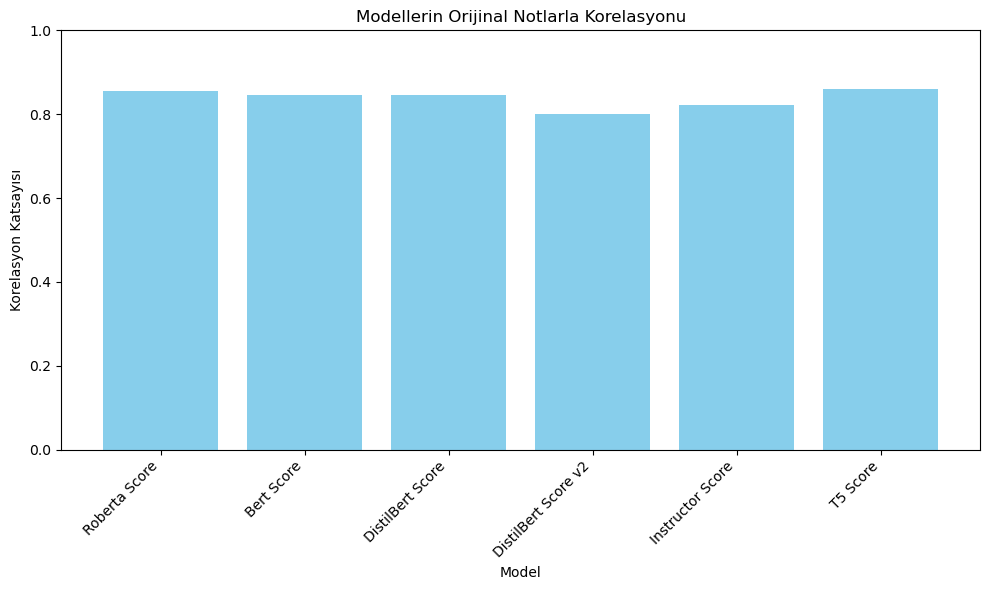

In [17]:
import matplotlib.pyplot as plt

# Korelasyon değerlerini görselleştirmek
model_names = list(updated_correlations.keys())
correlation_values = list(updated_correlations.values())

plt.figure(figsize=(10, 6))
plt.bar(model_names, correlation_values, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Korelasyon Katsayısı')
plt.title('Modellerin Orijinal Notlarla Korelasyonu')
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)  # Korelasyon katsayılarının değer aralığı 0 ile 1 arasında olduğu için
plt.tight_layout()
plt.show()


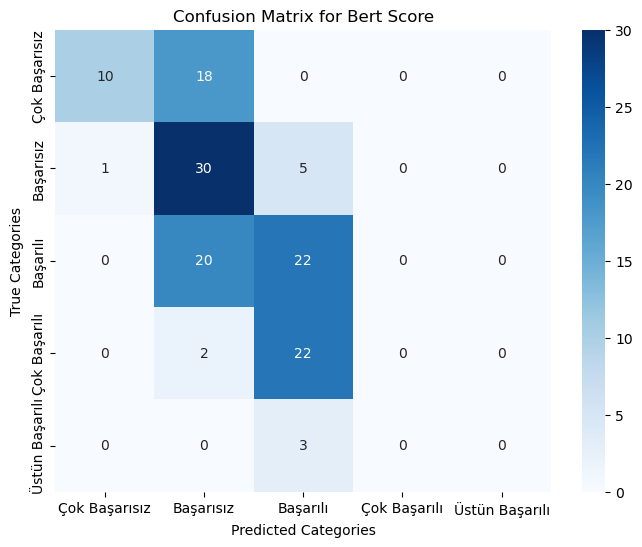

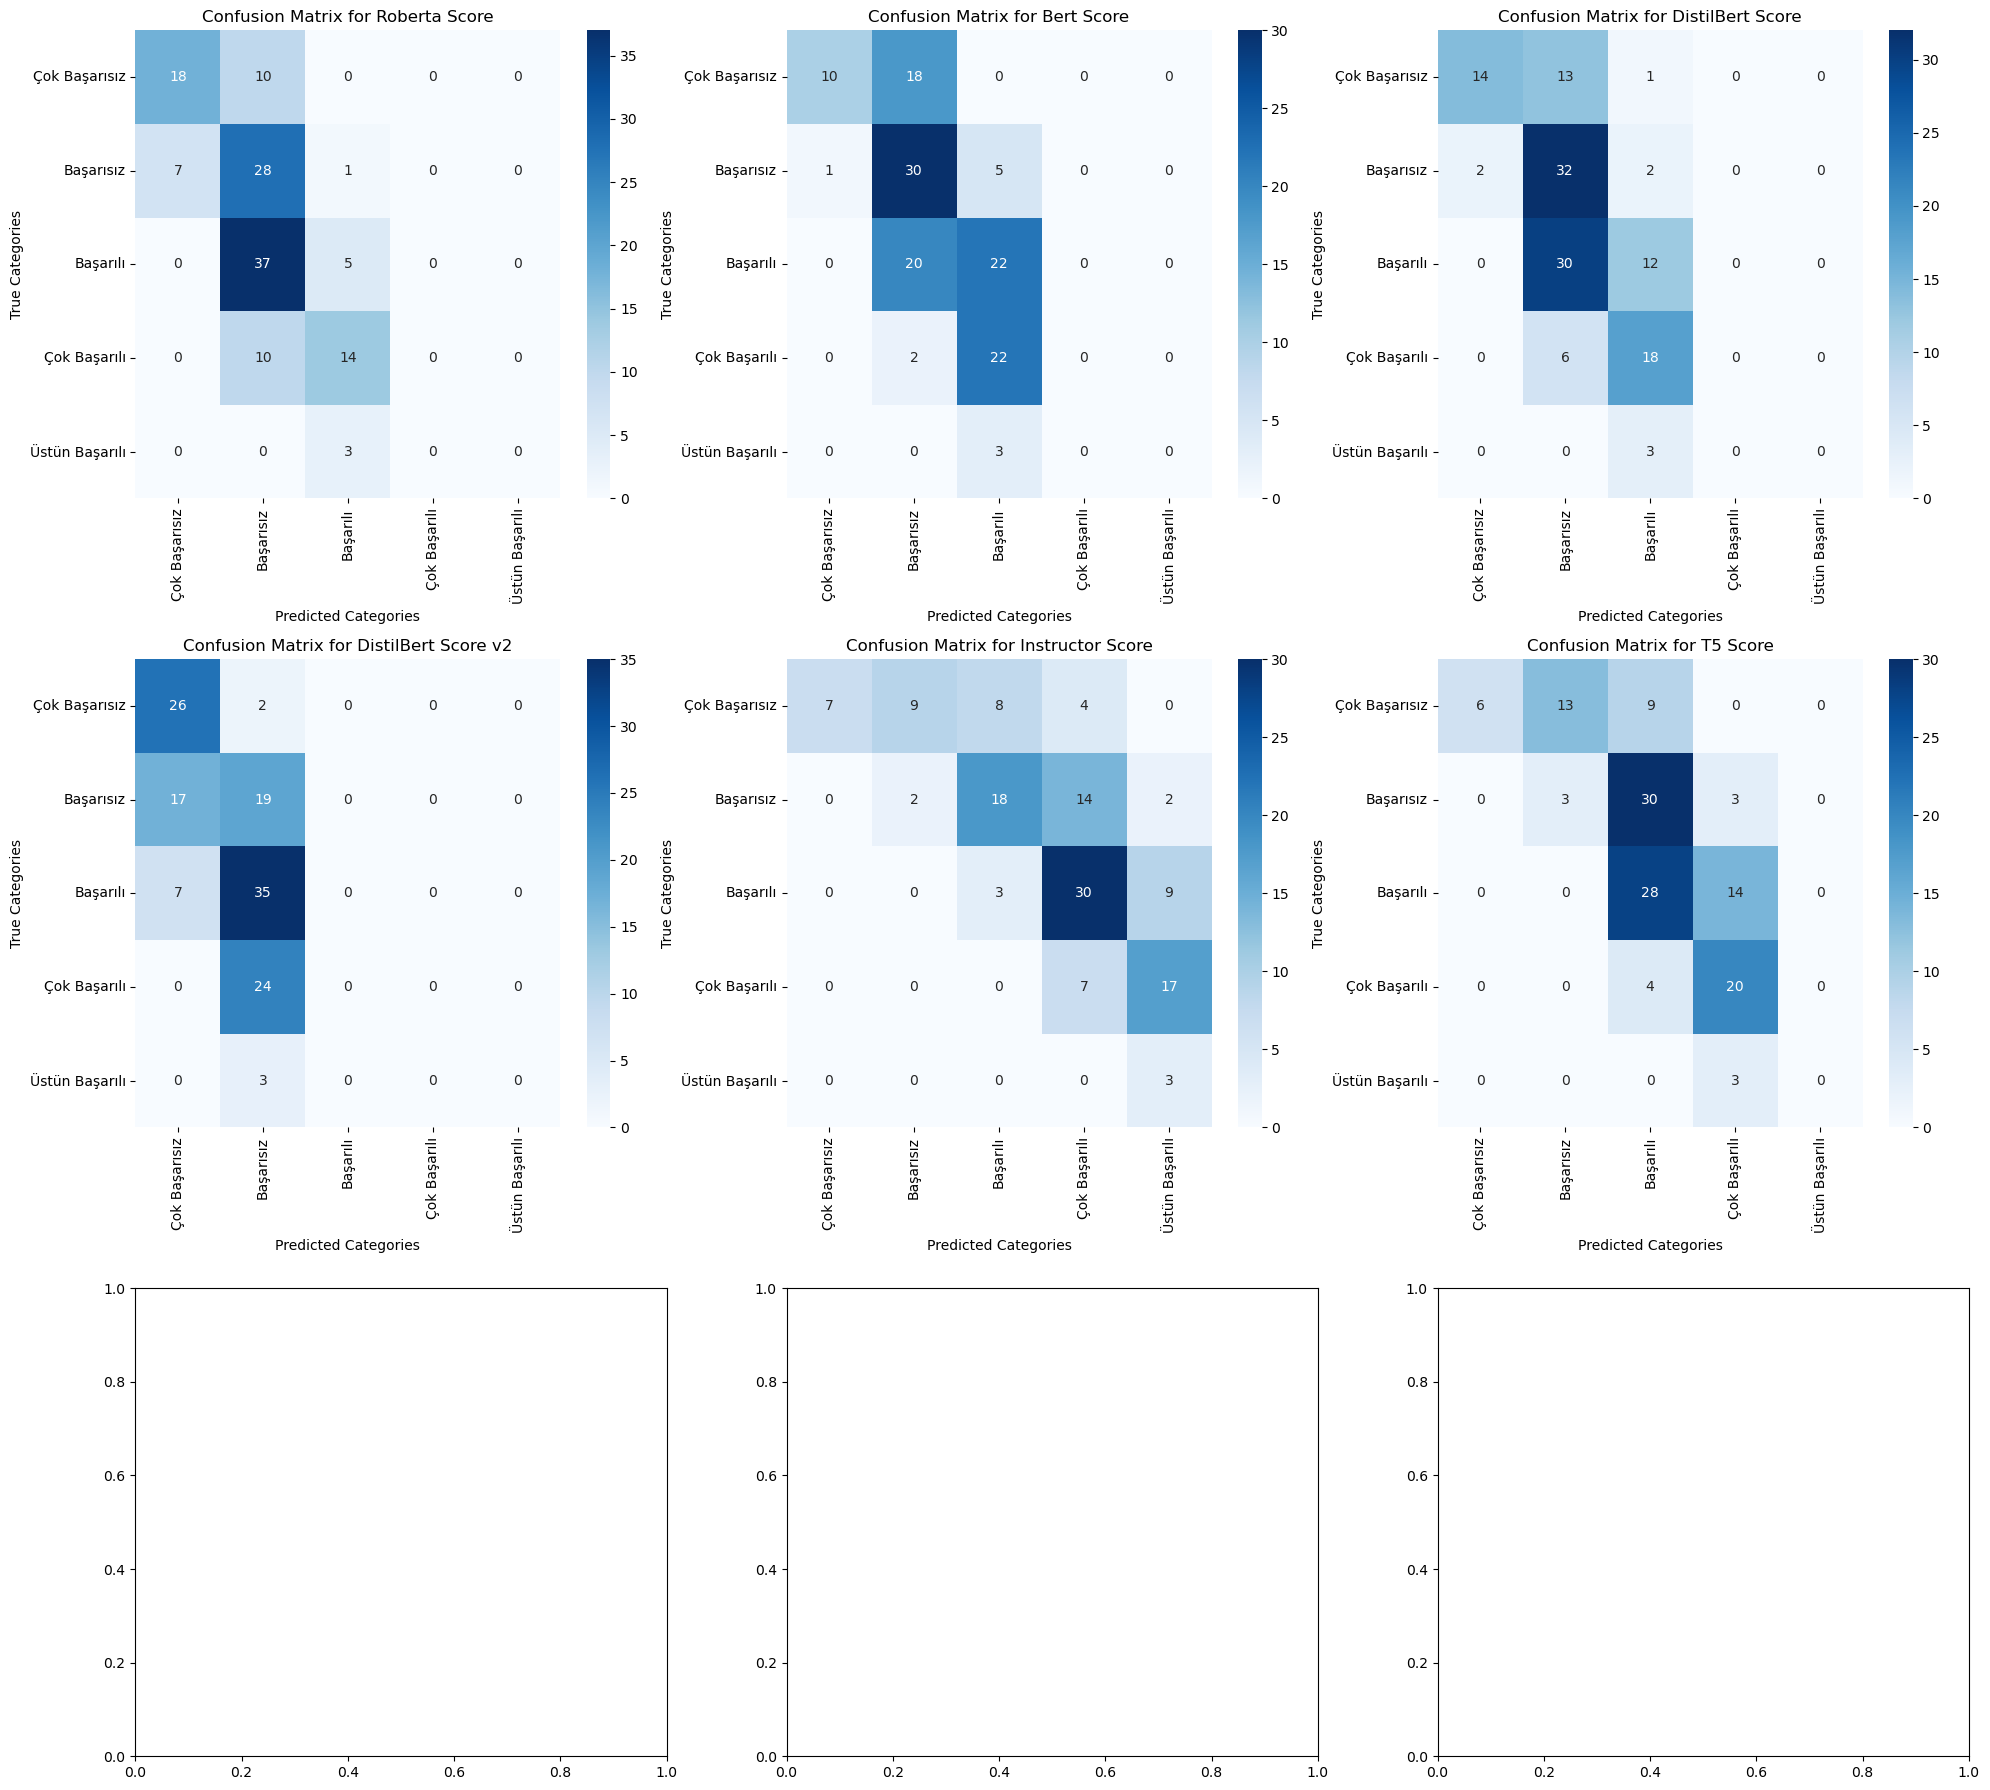

In [18]:
# Gerekli kütüphaneleri yeniden yükleyelim
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gerçek ve tahmin edilen kategorilerin sayısal değerlere eşlenmesi
category_mapping = {'Çok Başarısız': 0, 'Başarısız': 1, 'Başarılı': 2, 'Çok Başarılı': 3, 'Üstün Başarılı': 4}

# Güncellenmiş Excel dosyasını tekrar yükleme
updated_file_path = 'total_sonuc_keywords.xlsx'
updated_total_sonuc_df = pd.read_excel(updated_file_path, sheet_name='total_sonuc_keywords')

def categorize_score(score):
    if score <= 20:
        return 'Çok Başarısız'
    elif score <= 40:
        return 'Başarısız'
    elif score <= 60:
        return 'Başarılı'
    elif score <= 80:
        return 'Çok Başarılı'
    else:
        return 'Üstün Başarılı'

# Orijinal ve model notlarını kategorilere ayırma
categorized_scores_updated = updated_total_sonuc_df.drop(['StudentID'], axis=1).applymap(categorize_score)

# Gerçek ve tahmin edilen kategorileri sayısal değerlere dönüştürme
y_true = categorized_scores_updated['Score'].map(category_mapping)
y_pred = categorized_scores_updated['Bert Score'].map(category_mapping)

# Confusion matrisini hesaplama
conf_mat = confusion_matrix(y_true, y_pred)

# Confusion matrisini görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=category_mapping.keys(), yticklabels=category_mapping.keys())
plt.title('Confusion Matrix for Bert Score')
plt.xlabel('Predicted Categories')
plt.ylabel('True Categories')
plt.show()

# Confusion matrislerini her model için ayrı ayrı hesaplayıp görselleştirelim
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 18))
axes = axes.flatten()  # 2D eksen dizisini 1D'ye düzleştir

for i, model in enumerate(updated_model_names):
    # Gerçek ve tahmin edilen kategorileri sayısal değerlere dönüştürme
    y_pred = categorized_scores_updated[model].map(category_mapping)

    # Confusion matrisini hesaplama
    conf_mat = confusion_matrix(y_true, y_pred)

    # Confusion matrisini görselleştirme
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=category_mapping.keys(), yticklabels=category_mapping.keys())
    axes[i].set_title(f'Confusion Matrix for {model}')
    axes[i].set_xlabel('Predicted Categories')
    axes[i].set_ylabel('True Categories')

plt.tight_layout()
plt.show()


In [19]:
# Gerekli kütüphaneleri yeniden yükleyelim
import numpy as np

# Her model için doğru sınıflandırma ve yanlış sınıflandırma sayılarını hesaplayalım
model_performance = {}

for model in updated_model_names:
    y_pred = categorized_scores_updated[model].map(category_mapping)
    conf_mat = confusion_matrix(y_true, y_pred)
    
    # Doğru sınıflandırmalar (diyagonal üzerindeki değerlerin toplamı)
    correct_classifications = np.trace(conf_mat)
    
    # Yanlış sınıflandırmalar (toplam değerlerden doğru sınıflandırmaları çıkararak)
    total_classifications = np.sum(conf_mat)
    incorrect_classifications = total_classifications - correct_classifications
    
    # Performansı kaydet
    model_performance[model] = {
        "Correct Classifications": correct_classifications,
        "Incorrect Classifications": incorrect_classifications,
        "Total Classifications": total_classifications,
        "Accuracy": correct_classifications / total_classifications
    }

# Performans metriklerini DataFrame'e dönüştürme ve sıralama
model_performance_df = pd.DataFrame(model_performance).T.sort_values(by="Accuracy", ascending=False)

model_performance_df


,Correct Classifications,Incorrect Classifications,Total Classifications,Accuracy
Bert Score,62.0,71.0,133.0,0.466165
DistilBert Score,58.0,75.0,133.0,0.436090
T5 Score,57.0,76.0,133.0,0.428571
Roberta Score,51.0,82.0,133.0,0.383459
DistilBert Score v2,45.0,88.0,133.0,0.338346
Instructor Score,22.0,111.0,133.0,0.165414


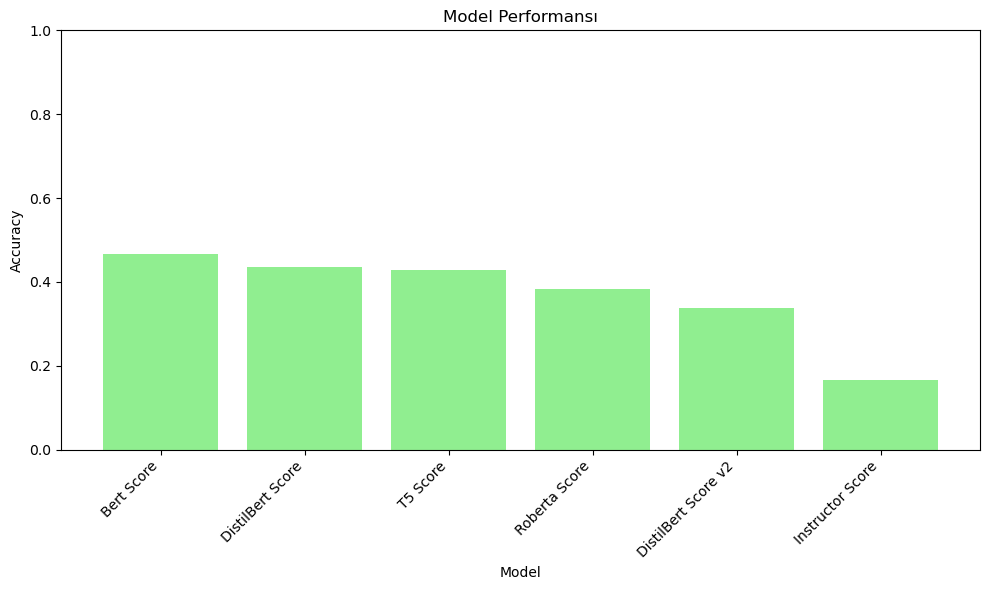

In [20]:
#her modelin başarısını görselleştirelim
plt.figure(figsize=(10, 6))
plt.bar(model_performance_df.index, model_performance_df['Accuracy'], color='lightgreen')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Performansı')
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
